In [64]:
import pandas as pd
from copy import deepcopy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import numpy as np
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
import xgboost as xgb
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')

In [49]:
# init df
df = pd.read_csv('titanic.csv', sep=";")

In [50]:
sex = df[['PassengerId', 'Sex']]
pd.get_dummies(sex, columns=['Sex'])

age = df[['PassengerId', 'Age']]

age['age_bins'] = pd.cut(df['Age'], bins=4)

age = pd.get_dummies(age, columns=['age_bins'])

In [96]:
df.head()

,Age,Fare,Pclass,SibSp,Parch,Sex,Survived
0,22.0,7.2500,3,1,0,1,0
1,38.0,71.2833,1,1,0,0,1
2,26.0,7.9250,3,0,0,0,1
3,35.0,53.1000,1,1,0,0,1
4,35.0,8.0500,3,0,0,1,0


In [59]:
# preprocess data
cols = list(df.columns)
a, b = cols.index('Survived'), cols.index('Embarked')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

df.drop(["Embarked", "PassengerId", "Cabin", "Ticket", "Name"], axis=1, inplace=True)

df = df.replace({'Sex': {'female': 0, 'male': 1}})

df = df.drop(df[(df.Sex == 'unknown') | (df.Age == 'NaN')].index)

df = df.dropna()

df = df.reset_index(drop=True)

cols = list(df.columns)
a, b = cols.index('Pclass'), cols.index('Age')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

cols = list(df.columns)
a, b = cols.index('Fare'), cols.index('Sex')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]


train_df, test_df = train_test_split(df, test_size=0.3)

x_train, y_train = train_df.to_numpy()[:,:-1], train_df.to_numpy()[:,-1]
x_test, y_test = test_df.to_numpy()[:,:-1], test_df.to_numpy()[:,-1]


std_scaler = StandardScaler().fit(x_train[:, :2])
minmax_scaler = MinMaxScaler().fit(x_train[:, 2:])

def preprocessor(X):
    A = deepcopy(X)
    A[:, :2] = std_scaler.transform(X[:, :2])
    A[:, 2:] = minmax_scaler.transform(X[:, 2:])
    return A

preprocessor_transformer = FunctionTransformer(preprocessor)

p1 = Pipeline([('Scaler', preprocessor_transformer),
              ('Logistic Regression', LogisticRegression())])

y_train=y_train.astype('int')

In [60]:
# training model
p1.fit(x_train, y_train)
train_pred_prob = p1.predict_proba(x_train)[:, 1]
test_pred_prob = p1.predict_proba(x_test)[:, 1]
train_pred = p1.predict(x_train)
test_pred = p1.predict(x_test)

In [61]:
def goeGINI(y_true, y_pred_proba):
    y_pred_proba = pd.Series(y_pred_proba) 
    y_pred = np.array(y_pred_proba.map(lambda x: 1 if x > 0.5 else 0))
    final_prob_target_and_class = np.column_stack([y_pred_proba.T, y_pred.T, y_true.T]).astype(float)
    final_prob_target_and_class = final_prob_target_and_class[np.argsort(final_prob_target_and_class[:, 0])][::-1]
    match = np.zeros((final_prob_target_and_class.shape[0],))

    for i in range(final_prob_target_and_class.shape[0]):
        match[i] = final_prob_target_and_class[i, 2]
    print(match)
    n = match.sum().astype(int)
    m = (match.shape[0]-n).astype(int)

    coord_y = np.linspace(0, 1, num = n+1)
    coord_x = np.linspace(0, 1, num = m+1)
    coords = np.zeros((n+m+1, 2))

    h_i = w_i = 0
    coords[0] = coord_x[0], coord_y[0]
    for i in range(1, n+m):
        if match[i-1] == 1:
            h_i += 1
        else:
            w_i += 1
        coords[i] = coord_x[w_i], coord_y[h_i]

    coords[-1] = 1, 1
    plt.scatter(coords[:, 0], coords[:, 1], marker = ",")
    plt.show()
    
    # fit polynomial w/ high degree
    deg = 100
    z = np.polyfit(coords[:, 0], coords[:, 1], deg)
    x = np.array(coords[:, 0])
    y = np.zeros((len(coords[:, 0],))) 

    for i in range(len(x)):
        for j in range(deg+1):
            y[i] += (z[j] * (x[i] ** (deg - j)))  
    y = y.clip(min=0, max=1)
    plt.plot(x, y)
    plt.plot(coords[:, 0], coords[:, 1])
    plt.show()
    aucroc = 0
    for i in range(deg+1):
        aucroc += z[i]/(deg-i+1)
    gini_doge = 2 * aucroc - 1
    gini_sklearn = 2 * roc_auc_score(final_prob_target_and_class[:, 2], final_prob_target_and_class[:, 0]) - 1 
    print(f"gini_doge = {gini_doge}\ngini_sklearn = {gini_sklearn}\nabs = {abs(gini_sklearn-gini_doge)}")
    

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


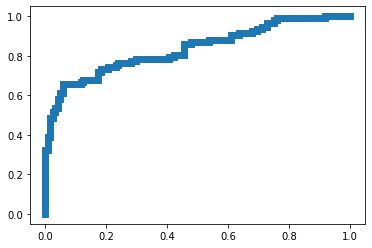

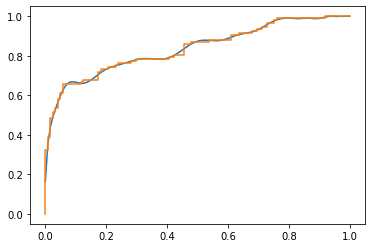

gini_doge = 0.671072213310874
gini_sklearn = 0.6729760952634853
abs = 0.0019038819526113748


In [62]:
goeGINI(y_test, test_pred_prob)

In [98]:
df2 = pd.read_csv('bank.csv')

In [99]:
df2.head()

,Unnamed: 0,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target
0,0,2736.0,1115.0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,1,3258.0,1177.0,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,2,2104.0,2040.0,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,3,5435.0,289.0,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,4,6899.0,1822.0,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0


In [43]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns=['target']), df2.target, test_size=0.2)

In [48]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [54]:
y_proba = clf.predict_proba(X_test)[:, 1]

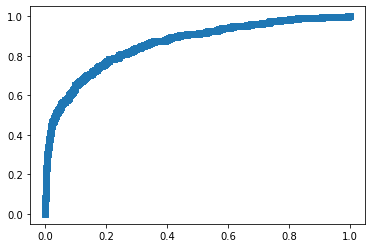

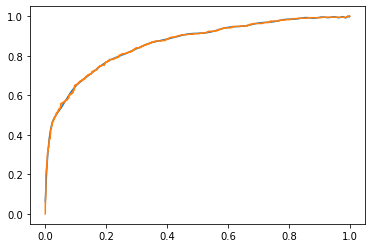

gini_doge = 0.7245444964111509
gini_sklearn = 0.7246861653641314
abs = 0.00014166895298051152


In [56]:
goeGINI(y_test, y_proba)

In [9]:
df3 = pd.read_csv('application_train.csv', sep=",")

In [100]:
df3.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0.083459,0.101419,0.085002,0.079616,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0.083459,0.069993,0.085002,0.083249,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0.054783,0.101419,0.072437,0.079616,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0.083459,0.069993,0.085002,0.079616,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0.083459,0.101419,0.085002,0.079616,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
for col in df3.select_dtypes(include='object'):
    df3[col] = df3[col].astype('category')

In [33]:
categorical_cols = df3.select_dtypes(include='category').columns
encoder = TargetEncoder()
encoder.fit(df3[categorical_cols], df3['TARGET'])
encoded_df = encoder.transform(df3[categorical_cols])
df3[categorical_cols] = encoded_df

In [36]:
for col in df3.select_dtypes(include='category'):
    df3[col] = df3[col].astype('float32')

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop(columns=['TARGET']), df3.TARGET, test_size=0.2)

In [40]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [42]:
y_pred_proba = clf.predict_proba(X_test)[:,1]

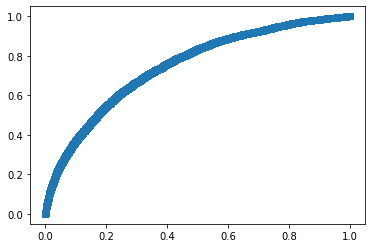

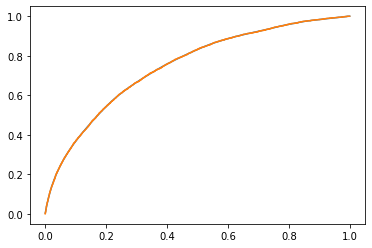

gini_doge = 0.4962548707720149
gini_sklearn = 0.4962558643765287
abs = 9.936045137770577e-07


In [46]:
goeGINI(y_test, y_pred_proba)

In [84]:
df4 = pd.read_csv('delay.csv', sep=",")

In [87]:
df4

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1


In [88]:
for col in df4.select_dtypes(include='object'):
    df4[col] = df4[col].astype('category')

In [89]:
categorical_cols = df4.select_dtypes(include='category').columns
encoder = TargetEncoder()
encoder.fit(df4[categorical_cols], df4['Class'])
encoded_df = encoder.transform(df4[categorical_cols])
df4[categorical_cols] = encoded_df

In [90]:
for col in df4.select_dtypes(include='category'):
    df4[col] = df4[col].astype('float32')

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df4.drop(columns=['Class']), df4.Class, test_size=0.2)

In [101]:
X_test

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek
269197,3117.0,1170.0,77.0,0.378944,0.490024,0.315648,3
487507,4282.0,680.0,83.0,0.397660,0.286853,0.344341,5
524606,645.0,555.0,165.0,0.388470,0.414776,0.436310,4
502146,3975.0,660.0,105.0,0.348104,0.479655,0.360641,4
484249,1329.0,985.0,65.0,0.697759,0.715998,0.548515,3
...,...,...,...,...,...,...,...
323210,654.0,860.0,85.0,0.697759,0.439931,0.492255,2
298200,221.0,1245.0,122.0,0.339290,0.532920,0.486322,6
5389,4249.0,810.0,110.0,0.397660,0.338689,0.351793,7
227713,755.0,1150.0,121.0,0.566199,0.484483,0.383769,7


In [92]:
clf = RandomForestClassifier()

In [93]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [94]:
y_proba = clf.predict_proba(X_test)[:, 1]

[0. 1. 1. ... 0. 0. 0.]


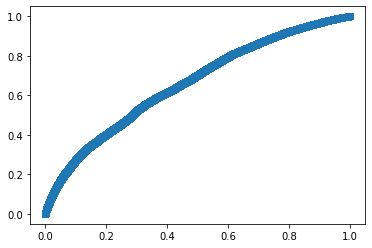

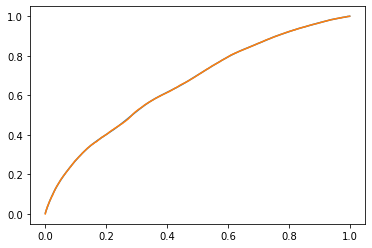

gini_doge = 0.3180925381460846
gini_sklearn = 0.31808532504450704
abs = 7.21310157758559e-06


In [95]:
goeGINI(y_test, y_proba)